In [1]:
from subpred.graph import (
    preprocess_data, get_substrate_matrix, create_heatmap, get_graph_plot
)

In [2]:
organism_names = ["athaliana"]  # "ecoli", "yeast", "human",

In [3]:
organism_name_to_id = {
    "ecoli":83333,
    "yeast":559292,
    "human":9606,
    "athaliana":3702
}
organism_ids={organism_name_to_id[organism_name] for organism_name in organism_names}
dataset_name="+".join(sorted(organism_names))

datasets_folder_path="data/datasets"
go_obo_path="data/raw/ontologies/go.obo"
chebi_obo_path="data/raw/ontologies/chebi.obo"
heatmap_output_path=f"plots/heatmap_{dataset_name}.png"
graph_output_path=f"plots/graph_{dataset_name}.png"
heatmap_title = f"Substrate molecular species overlaps for substrates with 20 or more transport proteins in dataset {dataset_name}"
graph_title = f"Relations between molecular species in for substrates with 20 or more transport proteins, only including abstractions\
      and tautomers, in dataset {dataset_name}"

Read datasets:

- Uniprot
- Uniprot GOA
- Ontologies
    - Chebi
    - GO

In [4]:
df_uniprot, df_uniprot_goa, graph_go, graph_chebi = preprocess_data(
    organism_ids=organism_ids,
    datasets_folder_path=datasets_folder_path,
    go_obo_path=go_obo_path,
    chebi_obo_path=chebi_obo_path,
)

43248
9136
2881
2881
287
164519
60547


## Substrate matrix 

In [5]:
df_substrate_overlaps_full, dict_chebi_to_uniprot_full = get_substrate_matrix(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    df_uniprot_goa=df_uniprot_goa,
    min_overlap=20,
    max_overlap=1000000,
    include_ancestor_chebi_ids=True
)

1996
245
244


## Heatmap

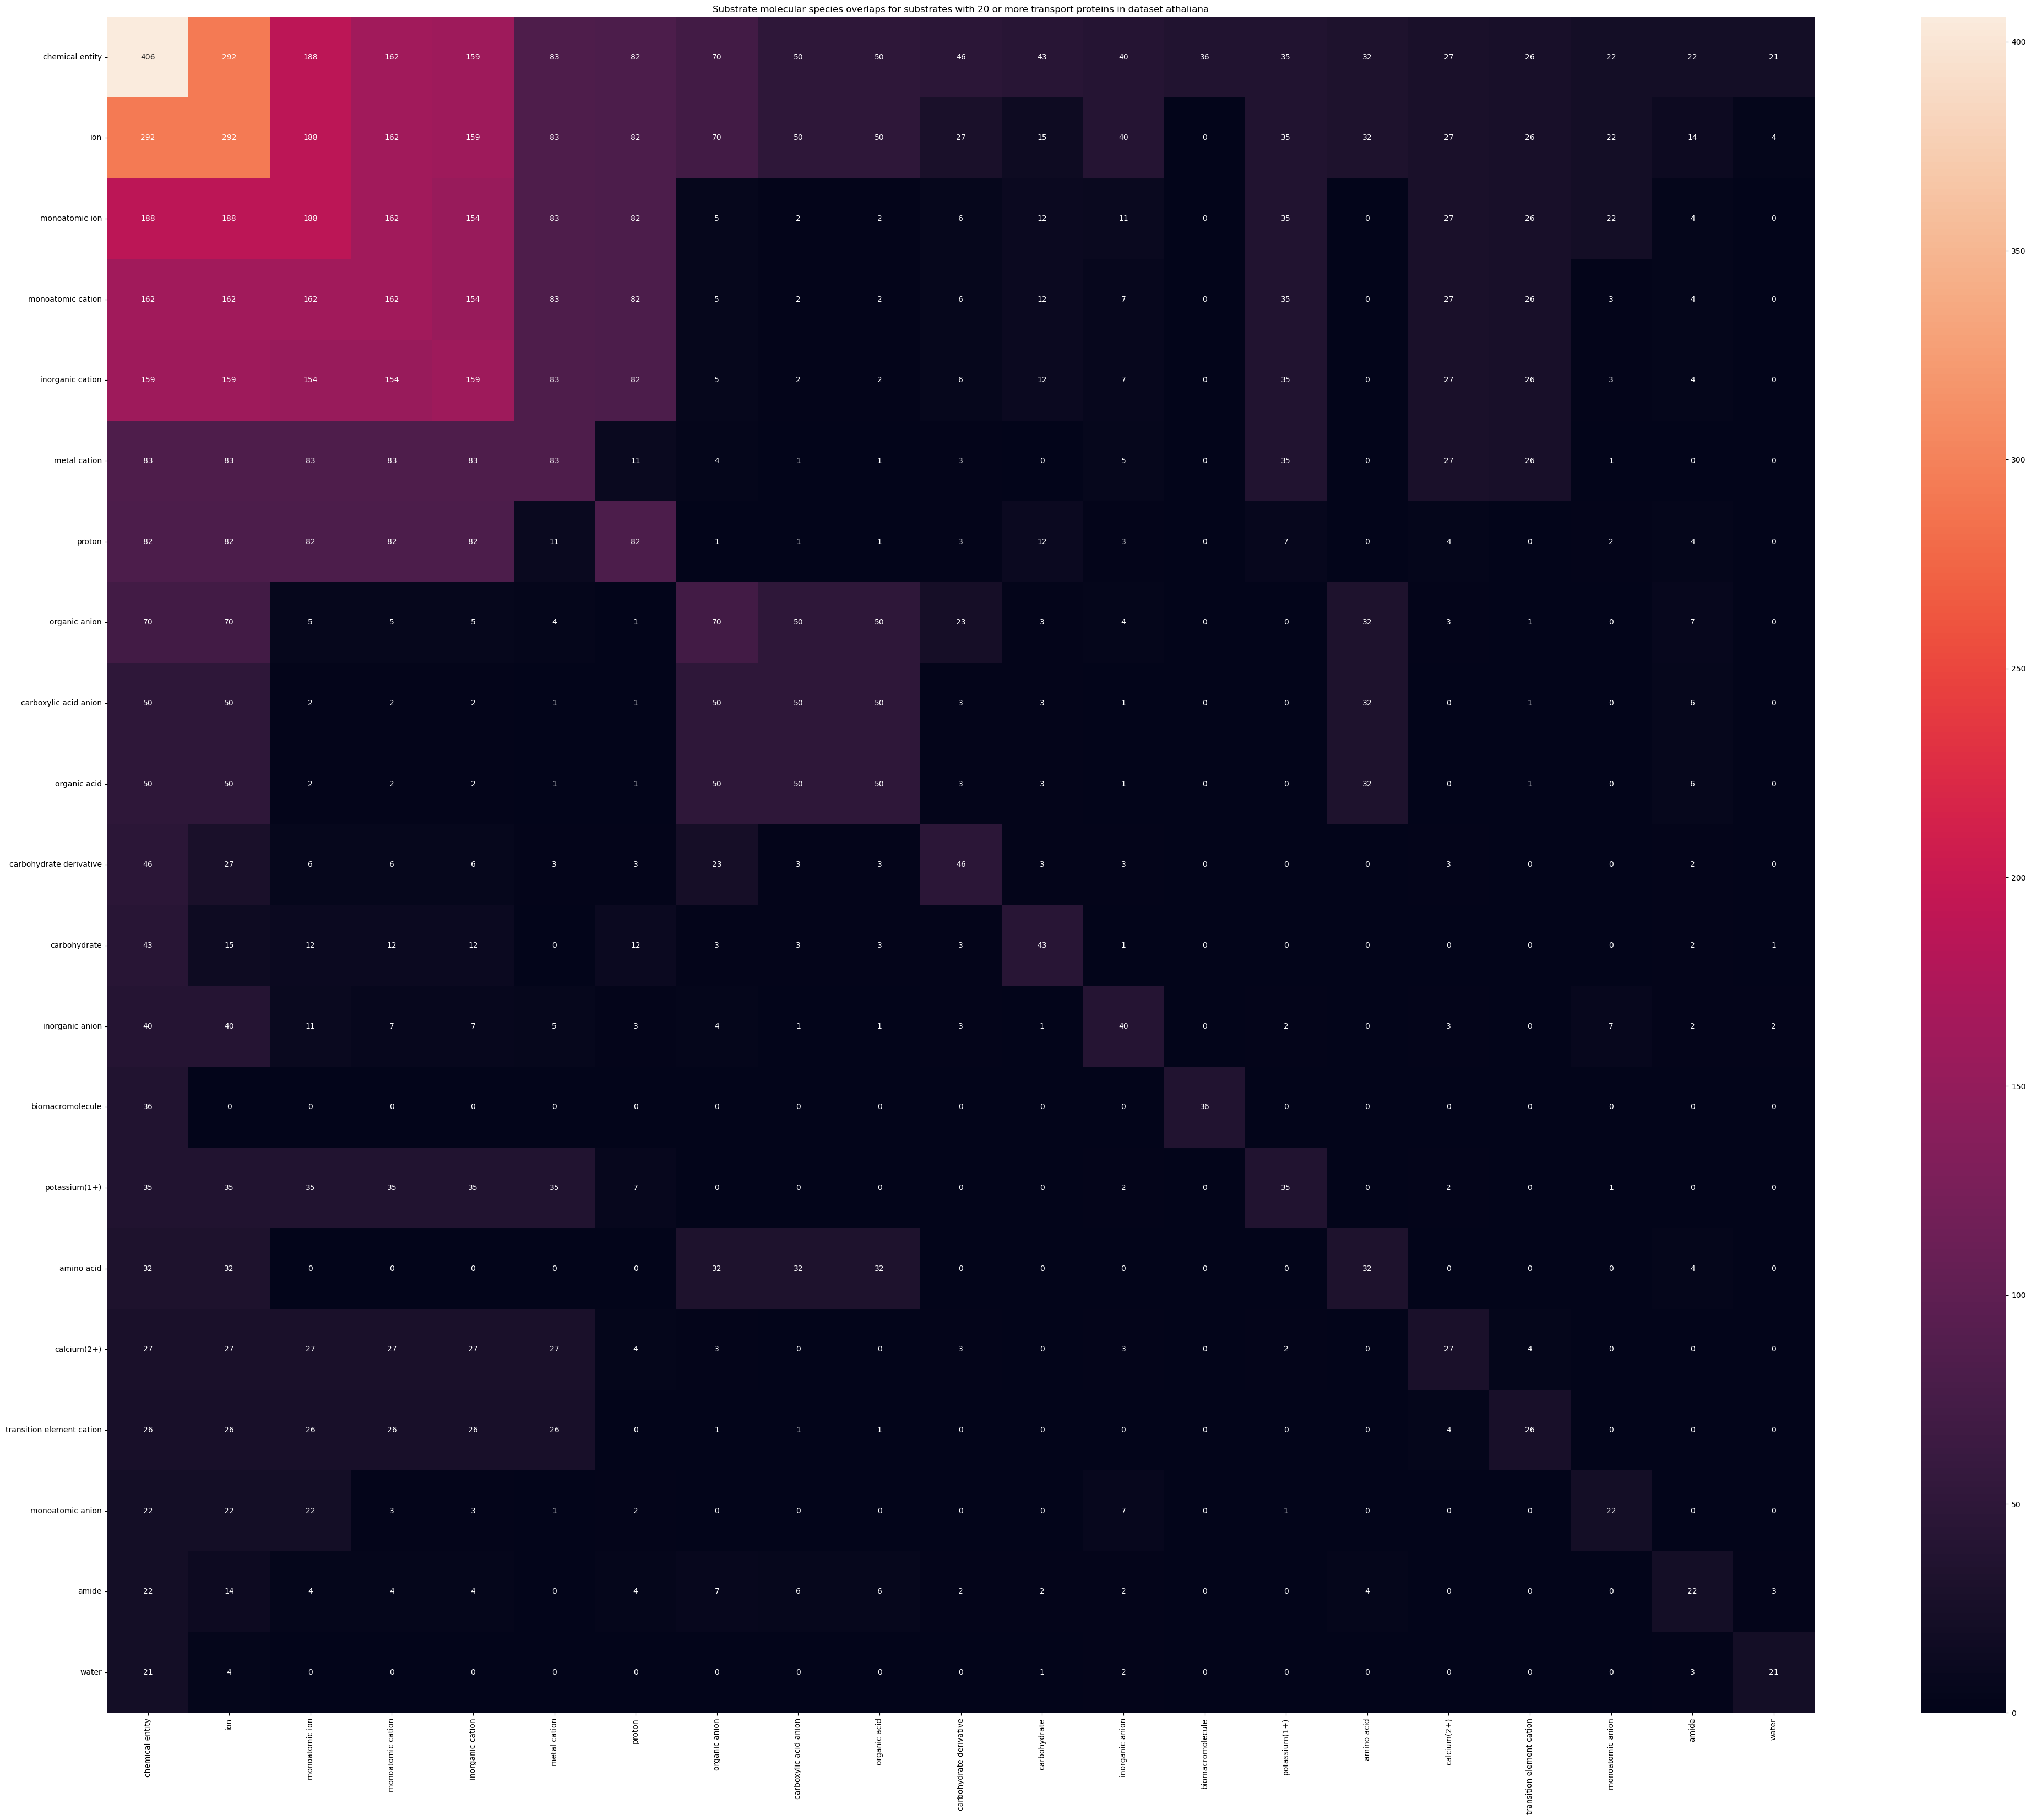

In [6]:
g = create_heatmap(
    df_matrix=df_substrate_overlaps_full,
    title=heatmap_title,
    width=50,
    height=40,
    lower_triangle_only=False,
    output_path=heatmap_output_path,
)
# from matplotlib import pyplot as plt
# g.figure.savefig("test.png",  bbox_inches='tight')

## Network

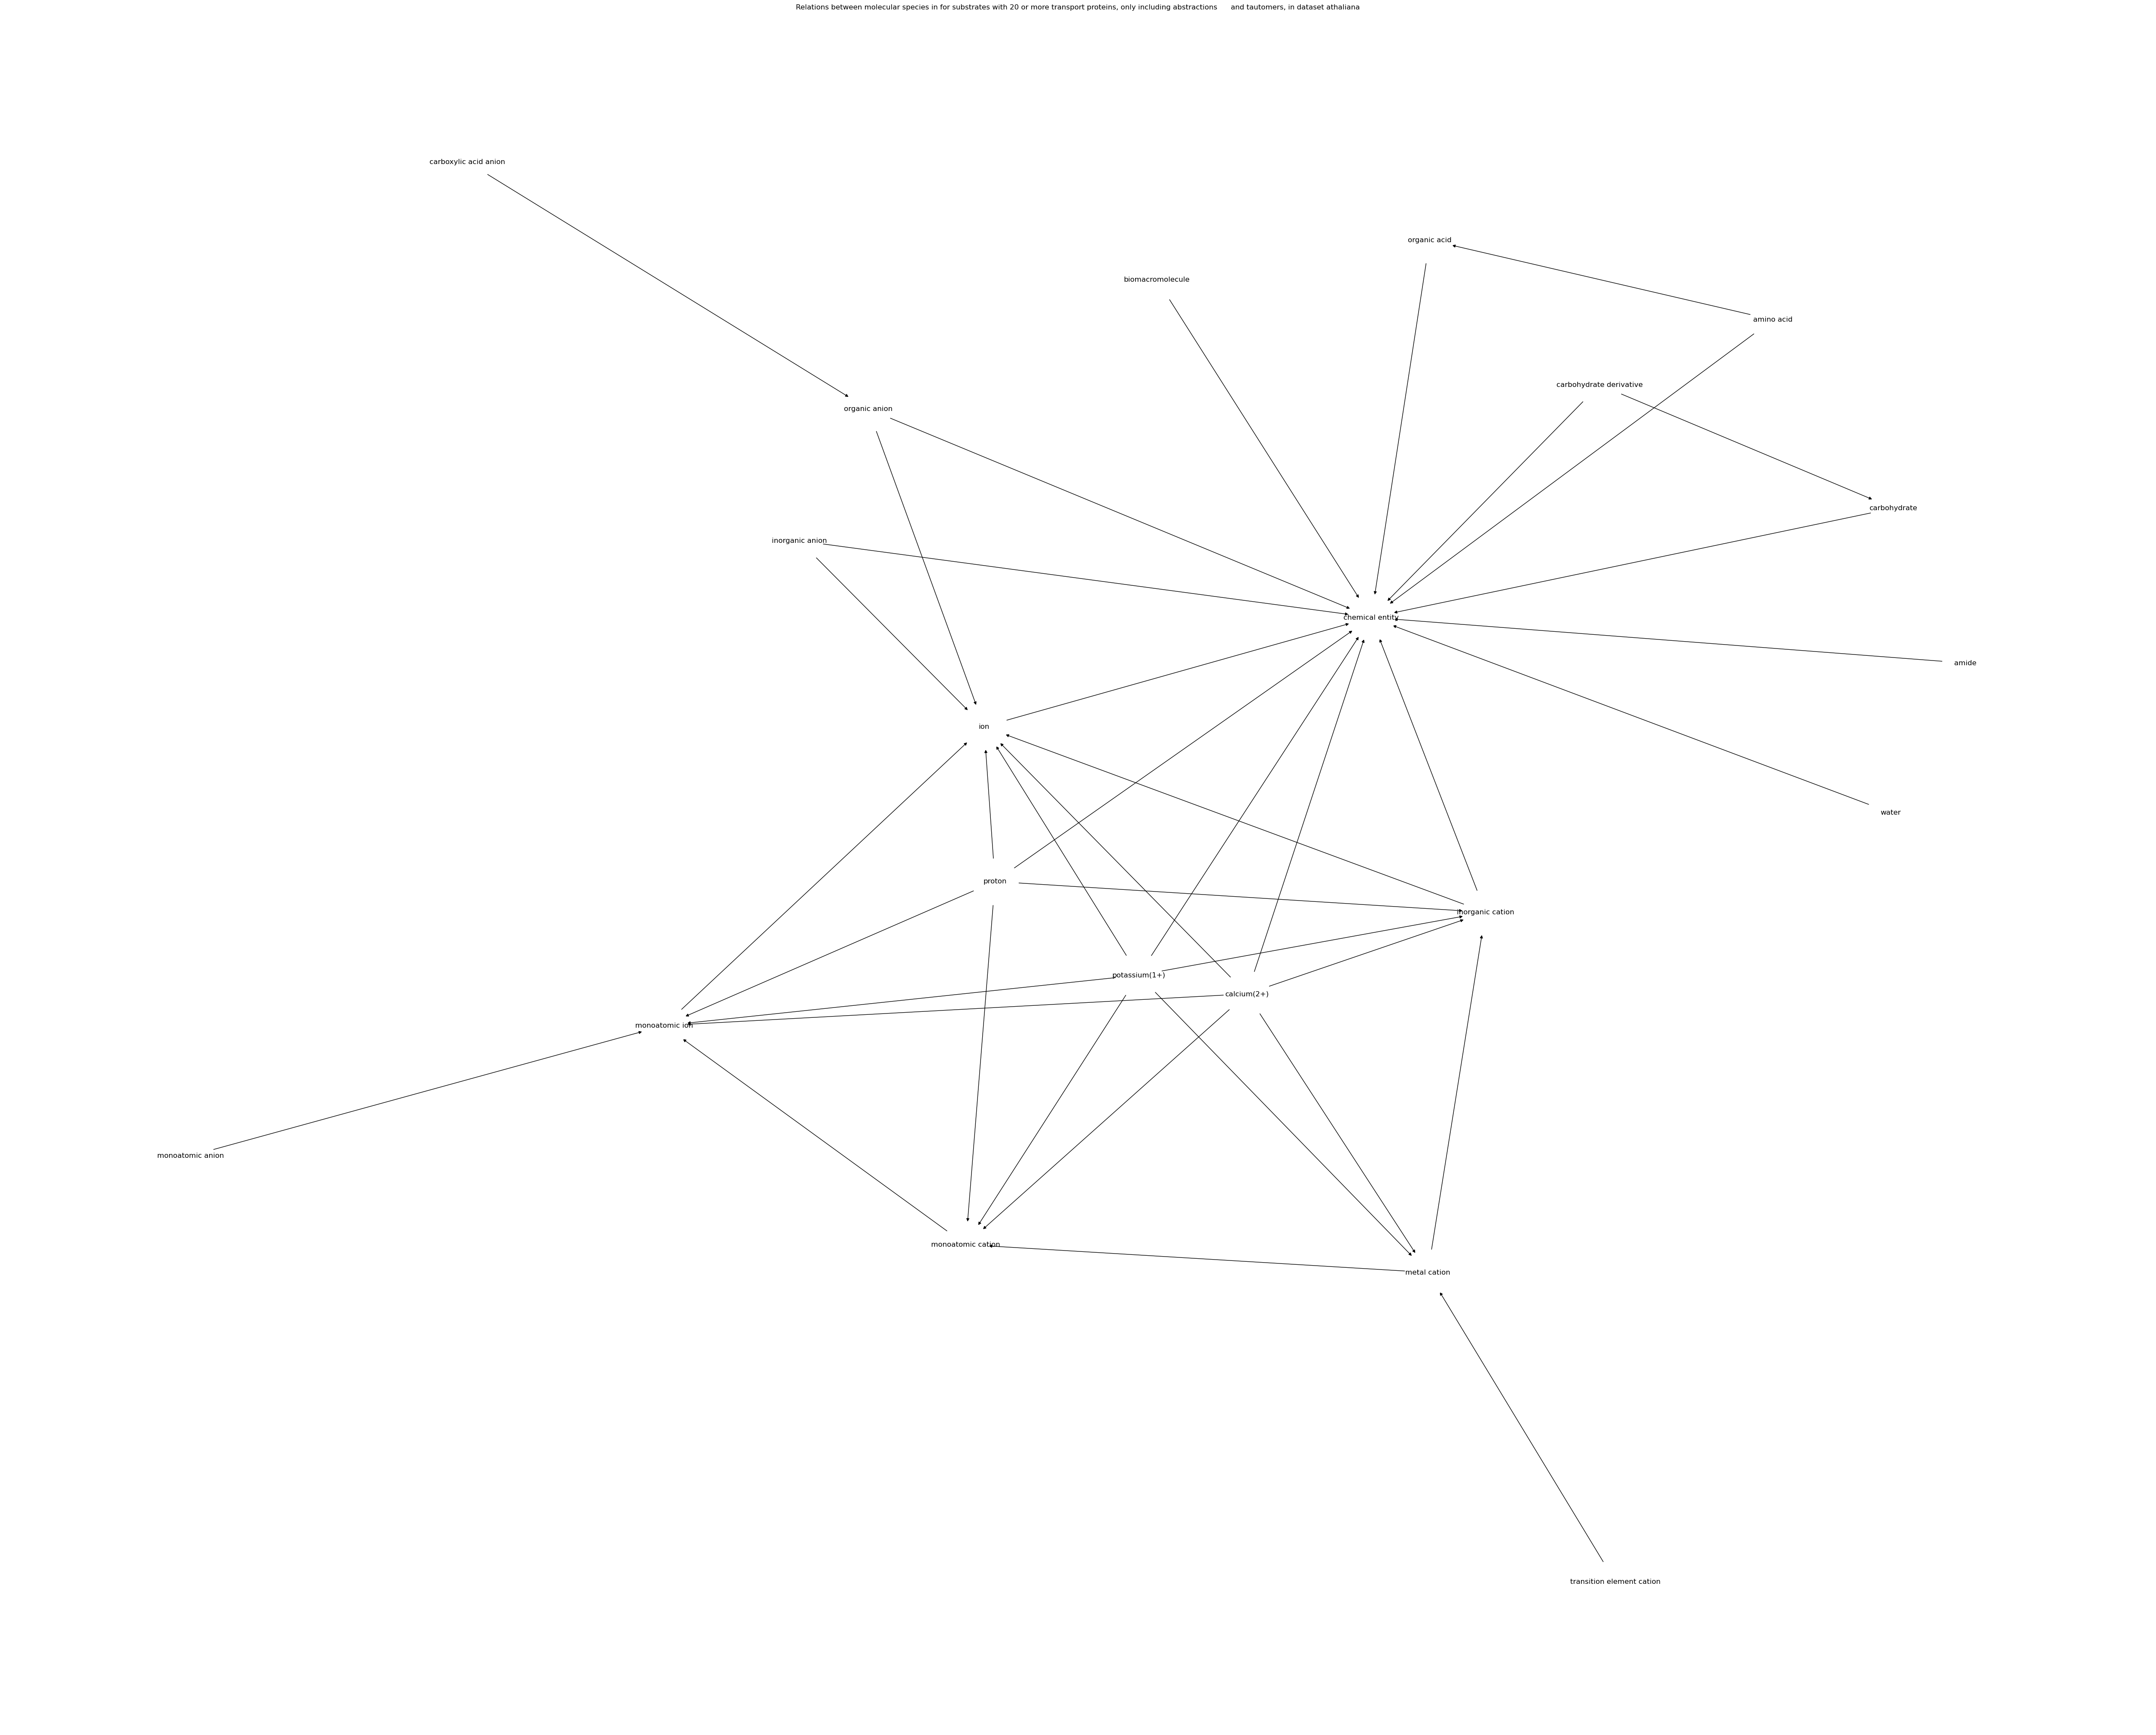

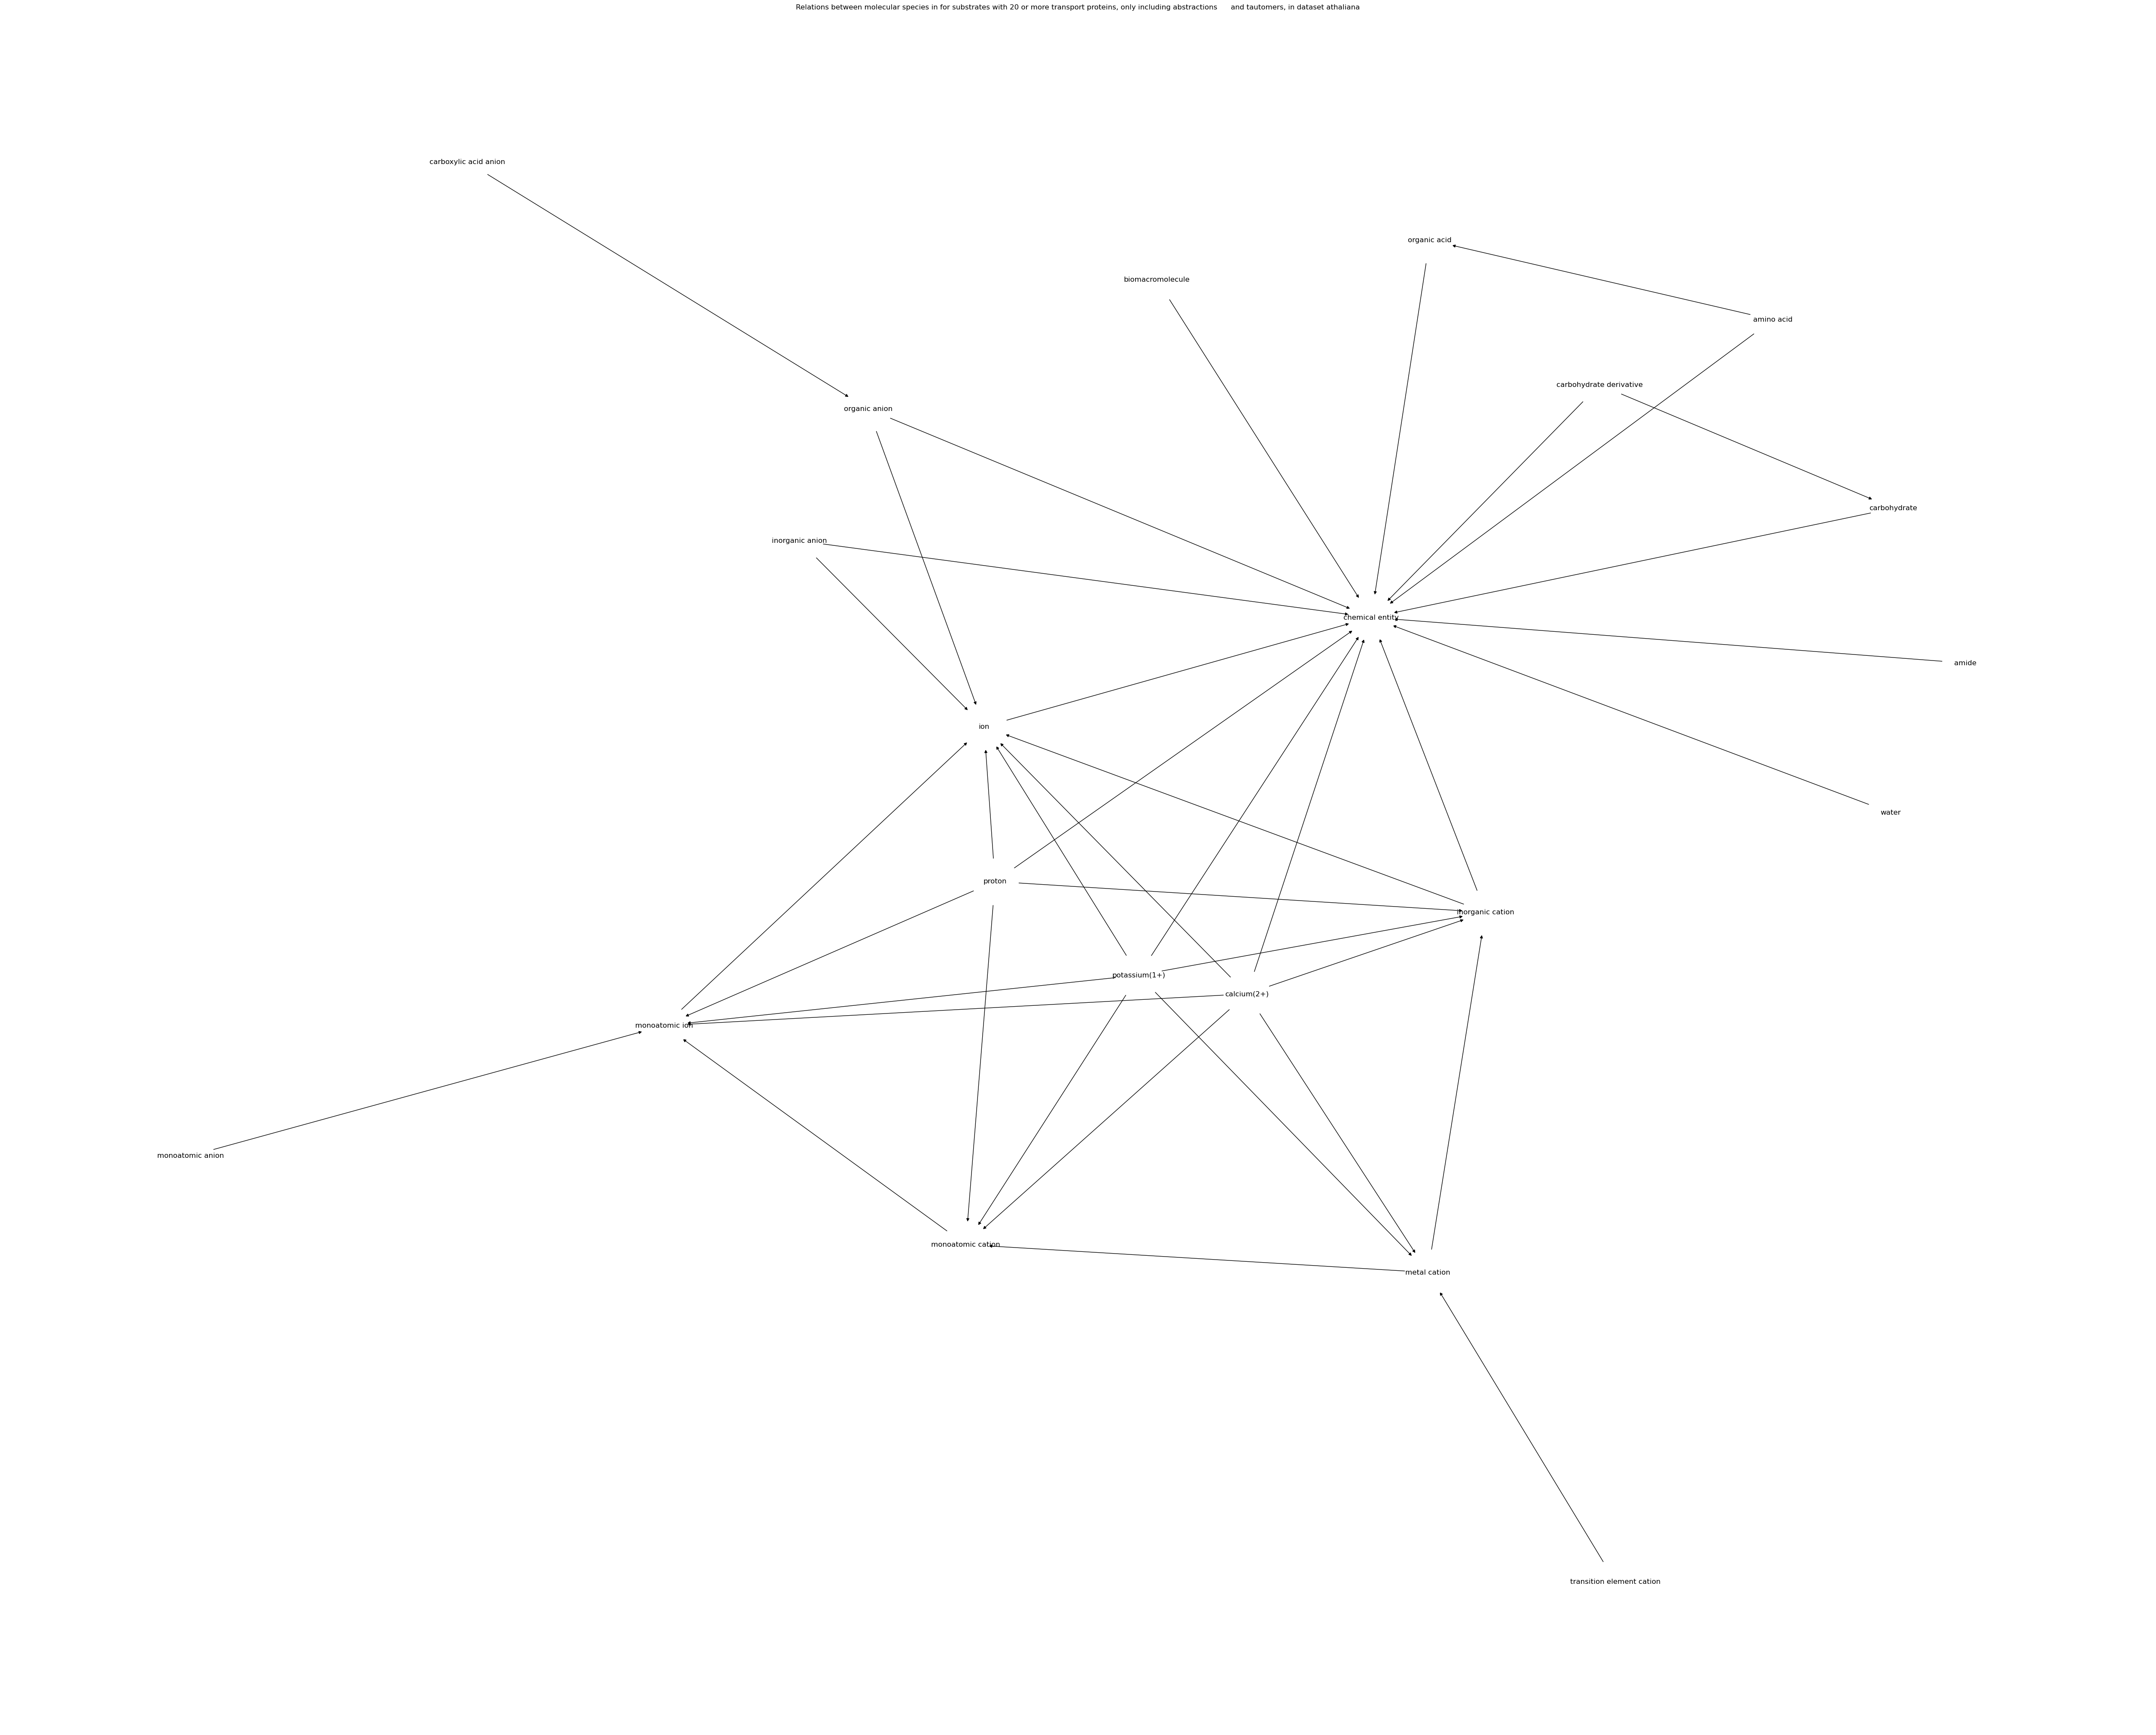

In [7]:
get_graph_plot(
    df_substrate_overlaps=df_substrate_overlaps_full,
    dict_chebi_to_uniprot=dict_chebi_to_uniprot_full,
    graph_chebi=graph_chebi,
    graph_output_path=graph_output_path,
    title=graph_title,
    node_size=6000,
    width=50,
    height=40,
    # relations_paths = {"is_a", "is_tautomer_of"}
)

## Questions

### Why are there overlaps between amino acid and ion?

Does it occur when not adding ancestors?

In [8]:
df_substrate_overlaps_noancestors, dict_chebi_to_uniprot_noancestors = get_substrate_matrix(
    datasets_folder_path=datasets_folder_path,
    graph_chebi=graph_chebi,
    graph_go=graph_go,
    df_uniprot_goa=df_uniprot_goa,
    min_overlap=20,
    max_overlap="half",
    include_ancestor_chebi_ids=False
)
df_substrate_overlaps_noancestors

1996
245
244


,monoatomic ion,monoatomic cation,inorganic cation,metal cation,proton,organic anion,carboxylic acid anion,organic acid,carbohydrate derivative,carbohydrate,...,biomacromolecule,potassium(1+),chemical entity,amino acid,calcium(2+),transition element cation,monoatomic anion,amide,water,ion
monoatomic ion,188,162,154,83,82,5,2,2,6,12,...,0,35,33,0,27,26,22,4,0,20
monoatomic cation,162,162,154,83,82,5,2,2,6,12,...,0,35,33,0,27,26,3,4,0,20
inorganic cation,154,154,159,83,82,5,2,2,6,12,...,0,35,32,0,27,26,3,4,0,19
metal cation,83,83,83,83,11,4,1,1,3,0,...,0,35,10,0,27,26,1,0,0,15
proton,82,82,82,11,82,1,1,1,3,12,...,0,7,29,0,4,0,2,4,0,4
organic anion,5,5,5,4,1,70,50,50,23,3,...,0,0,1,32,3,1,0,7,0,0
carboxylic acid anion,2,2,2,1,1,50,50,50,3,3,...,0,0,1,32,0,1,0,6,0,0
organic acid,2,2,2,1,1,50,50,50,3,3,...,0,0,1,32,0,1,0,6,0,0
carbohydrate derivative,6,6,6,3,3,23,3,3,46,3,...,0,0,3,0,3,0,0,2,0,0
carbohydrate,12,12,12,0,12,3,3,3,3,43,...,0,0,12,0,0,0,0,2,1,0


In [9]:
df_substrate_overlaps_noancestors[["amino acid", "ion"]].loc[["amino acid", "ion"]]

,amino acid,ion
amino acid,32,0
ion,0,20


In [10]:
df_substrate_overlaps_full[["amino acid", "ion"]].loc[["amino acid", "ion"]]

,amino acid,ion
amino acid,32,32
ion,32,292


It only occurs when adding ancestors. Is there a direct path?

In [16]:
graph_chebi_isa = graph_chebi.edge_subgraph(
    [edge for edge in list(graph_chebi.edges(keys=True)) if edge[2] == "is_a"]
).copy()

In [17]:
import networkx as nx
name_to_id = {node[1]: node[0] for node in graph_chebi.nodes(data="name")}
id_to_name = {node[0]: node[1] for node in graph_chebi.nodes(data="name")}
path_amino_ion = nx.shortest_path(graph_chebi_isa, name_to_id["amino acid"], name_to_id["ion"])

[id_to_name[term] for term in path_amino_ion]

NetworkXNoPath: No path between CHEBI:33709 and CHEBI:24870.

Are there other shortest paths?

In [12]:
paths_amino_ion = nx.all_shortest_paths(graph_chebi, name_to_id["amino acid"], name_to_id["ion"])
[[id_to_name[term] for term in path_amino_ion] for path_amino_ion in paths_amino_ion]

[['amino acid',
  'carboxylic acid',
  'carboxylic acid anion',
  'organic anion',
  'organic ion',
  'ion'],
 ['amino acid',
  'amino-acid anion',
  'carboxylic acid anion',
  'organic anion',
  'organic ion',
  'ion'],
 ['amino acid',
  'carboxylic acid',
  'carboxylic acid anion',
  'organic anion',
  'anion',
  'ion'],
 ['amino acid',
  'amino-acid anion',
  'carboxylic acid anion',
  'organic anion',
  'anion',
  'ion']]

Simple paths?

In [13]:
paths_amino_ion = nx.all_simple_paths(graph_chebi, name_to_id["amino acid"], name_to_id["ion"])
[[id_to_name[term] for term in path_amino_ion] for path_amino_ion in paths_amino_ion]

[['amino acid',
  'organic amino compound',
  'ammonia',
  'ammonium',
  'monovalent inorganic cation',
  'inorganic cation',
  'inorganic ion',
  'ion'],
 ['amino acid',
  'organic amino compound',
  'ammonia',
  'ammonium',
  'monovalent inorganic cation',
  'inorganic cation',
  'cation',
  'ion'],
 ['amino acid',
  'organic amino compound',
  'ammonia',
  'azanide',
  'monovalent inorganic anion',
  'inorganic anion',
  'anion',
  'ion'],
 ['amino acid',
  'organic amino compound',
  'ammonia',
  'azanide',
  'monovalent inorganic anion',
  'inorganic anion',
  'inorganic ion',
  'ion'],
 ['amino acid',
  'organic amino compound',
  'ammonia',
  'azanide',
  'hydridonitrate(2-)',
  'divalent inorganic anion',
  'inorganic anion',
  'anion',
  'ion'],
 ['amino acid',
  'organic amino compound',
  'ammonia',
  'azanide',
  'hydridonitrate(2-)',
  'divalent inorganic anion',
  'inorganic anion',
  'inorganic ion',
  'ion'],
 ['amino acid',
  'carboxylic acid',
  'carboxylic acid anion

What types of edges does the path have?

In [14]:
paths_amino_ion = nx.all_simple_edge_paths(graph_chebi, name_to_id["amino acid"], name_to_id["ion"])
# [[id_to_name[term] for term in path_amino_ion] for path_amino_ion in paths_amino_ion]
list(paths_amino_ion)

[[('CHEBI:33709', 'CHEBI:50047', 'is_a'),
  ('CHEBI:50047', 'CHEBI:16134', 'has_parent_hydride'),
  ('CHEBI:16134', 'CHEBI:28938', 'is_conjugate_base_of'),
  ('CHEBI:28938', 'CHEBI:60242', 'is_a'),
  ('CHEBI:60242', 'CHEBI:36915', 'is_a'),
  ('CHEBI:36915', 'CHEBI:36914', 'is_a'),
  ('CHEBI:36914', 'CHEBI:24870', 'is_a')],
 [('CHEBI:33709', 'CHEBI:50047', 'is_a'),
  ('CHEBI:50047', 'CHEBI:16134', 'has_parent_hydride'),
  ('CHEBI:16134', 'CHEBI:28938', 'is_conjugate_base_of'),
  ('CHEBI:28938', 'CHEBI:60242', 'is_a'),
  ('CHEBI:60242', 'CHEBI:36915', 'is_a'),
  ('CHEBI:36915', 'CHEBI:36916', 'is_a'),
  ('CHEBI:36916', 'CHEBI:24870', 'is_a')],
 [('CHEBI:33709', 'CHEBI:50047', 'is_a'),
  ('CHEBI:50047', 'CHEBI:16134', 'has_parent_hydride'),
  ('CHEBI:16134', 'CHEBI:29337', 'is_conjugate_acid_of'),
  ('CHEBI:29337', 'CHEBI:79389', 'is_a'),
  ('CHEBI:79389', 'CHEBI:24834', 'is_a'),
  ('CHEBI:24834', 'CHEBI:22563', 'is_a'),
  ('CHEBI:22563', 'CHEBI:24870', 'is_a')],
 [('CHEBI:33709', 'CHEBI: